# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification

### Install Prerequisites

To run the app in the notebook environment, you must first install the required packages by executing the two cells below. **Make sure to restart the kernel after running each cell.**

> Note: Restarting the kernel ensures that all installed dependencies are properly loaded into the environment.

In [1]:
# Install requirements (skip requirements.txt — we install deps individually for compatibility)
!pip install livelossplot seaborn pandas tqdm ipywidgets --break-system-packages -q 2>/dev/null || pip install livelossplot seaborn pandas tqdm ipywidgets -q

In [2]:
# Please restart the notebook kernel after running this cell as well.
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console dejavu events execute kernel kernelspec lab
labextension labhub migrate nbconvert notebook run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


### A Simple App

In this notebook we build a very simple app that uses our exported model.

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Note how we are not importing anything from our source code (we do not use any module from the ``src`` directory). This is because the exported model, differently from the model weights, is a standalone serialization of our model and therefore it does not need anything else. You can ship that file to anybody, and as long as they can import ``torch``, they will be able to use your model. This is very important for releasing pytorch models to production.

### Test Your App
Go to a search engine for images (like Google Images) and search for images of some of the landmarks, like the Eiffel Tower, the Golden Gate Bridge, Machu Picchu and so on. Save a few examples locally, then upload them to your app to see how your model behaves!

The app will show the top 5 classes that the model think are most relevant for the picture you have uploaded

In [3]:
from ipywidgets import VBox, Button, FileUpload, Output, Label
from PIL import Image
from IPython.display import display
import io
import numpy as np
import torchvision
import torchvision.transforms as T
import torch

# Load the transfer learning model (best performance)
learn_inf = torch.jit.load("checkpoints/transfer_exported.pt")

def on_click_classify(change):

    # Load image that has been uploaded
    fn = io.BytesIO(btn_upload.data[-1])

    img = Image.open(fn)
    img.load()

    # Let's clear the previous output (if any)
    out_pl.clear_output()

    # Display the image
    with out_pl:

        ratio = img.size[0] / img.size[1]
        c = img.copy()
        c.thumbnail([ratio * 200, 200])
        display(c)

    # Transform to tensor
    timg = T.ToTensor()(img).unsqueeze_(0)

    # Calling the model
    softmax = learn_inf(timg).data.cpu().numpy().squeeze()
    
    # Get the indexes of the classes ordered by softmax
    # (larger first)
    idxs = np.argsort(softmax)[::-1]
    
    # Loop over the classes with the largest softmax
    for i in range(5):
        # Get softmax value
        p = softmax[idxs[i]]
    
        # Get class name
        landmark_name = learn_inf.class_names[idxs[i]]
        
        labels[i].value = f"{landmark_name} (prob: {p:.2f})"


# Putting back btn_upload to a widget for next cell
btn_upload = FileUpload()

btn_run = Button(description="Classify")
btn_run.on_click(on_click_classify)

labels = []
for _ in range(5):
    labels.append(Label())

out_pl = Output()
out_pl.clear_output()

wgs = [Label("Please upload a picture of a landmark"), btn_upload, btn_run, out_pl]
wgs.extend(labels)

VBox(wgs)

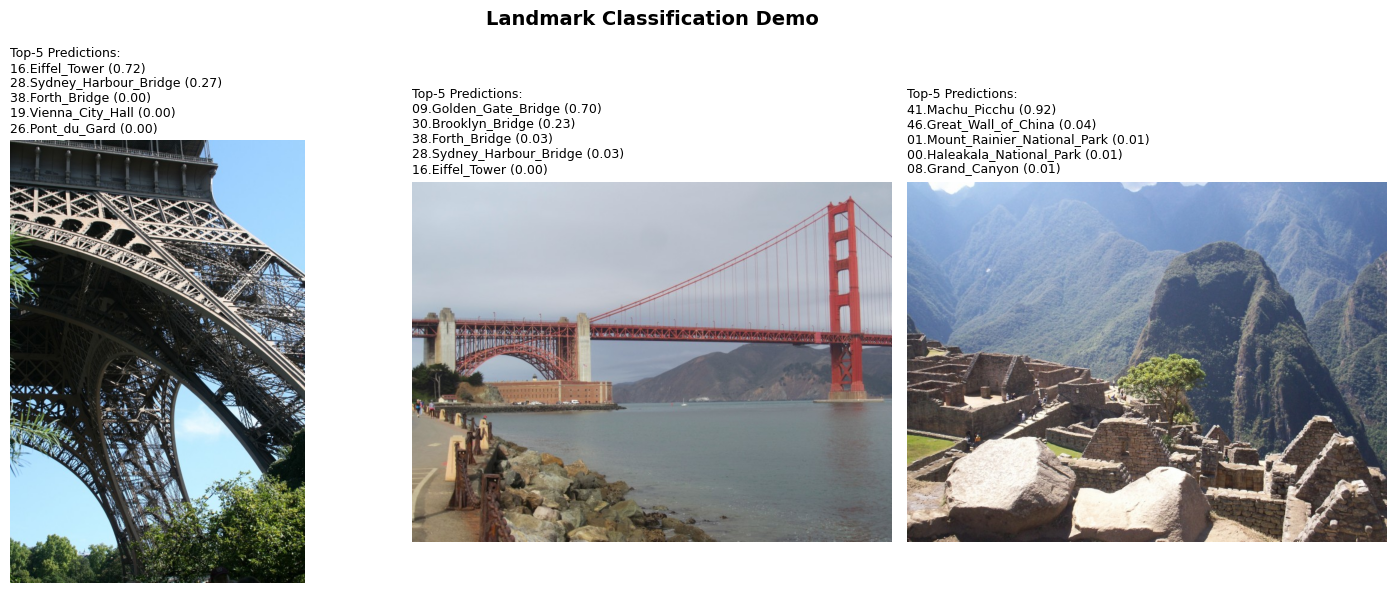

In [4]:
import torch
import torchvision.transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Load the transfer learning model
learn_inf = torch.jit.load("checkpoints/transfer_exported.pt")

# Use landmark images from static_images/ (not part of the training/test datasets)
sample_images = [
    Path("static_images/test/16.Eiffel_Tower/3828627c8730f160.jpg"),
    Path("static_images/test/09.Golden_Gate_Bridge/190f3bae17c32c37.jpg"),
    Path("static_images/test/41.Machu_Picchu/4336abf3179202f2.jpg"),
]

fig, axes = plt.subplots(1, len(sample_images), figsize=(5 * len(sample_images), 6))

for ax, img_path in zip(axes, sample_images):
    img = Image.open(img_path).convert("RGB")
    
    # Transform and classify
    timg = T.ToTensor()(img).unsqueeze_(0)
    softmax = learn_inf(timg).data.cpu().numpy().squeeze()
    idxs = np.argsort(softmax)[::-1]
    
    # Display image
    ax.imshow(img)
    ax.axis('off')
    
    # Show top-5 predictions
    pred_text = "\n".join(
        f"{learn_inf.class_names[idxs[i]]} ({softmax[idxs[i]]:.2f})"
        for i in range(5)
    )
    ax.set_title(f"Top-5 Predictions:\n{pred_text}", fontsize=9, loc='left')

plt.suptitle("Landmark Classification Demo", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## (Optional) Standalone App or Web App

You can run this notebook as a standalone app on your computer by following these steps:

1. Download this notebook in a directory on your machine
2. Download the model export (for example, ``checkpoints/transfer_exported.pt``) in a subdirectory called ``checkpoints`` within the directory where you save the app.ipynb notebook
3. Install voila if you don't have it already (``pip install voila``)
4. Run your app: ``voila app.ipynb --show_tracebacks=True``
5. Customize your notebook to make your app prettier and rerun voila

You can also deploy this app as a website using Binder: https://voila.readthedocs.io/en/stable/deploy.html#deployment-on-binder

---
## Stand Out: Additional Use Cases

A landmark classification model like ours has several practical applications beyond simple identification:

1. **Travel Recommendation Engine:** Given a user's photo library, automatically identify which landmarks they've visited and recommend similar destinations. For example, if someone has photos of European cathedrals, suggest other Gothic architecture sites they haven't visited.

2. **Automatic Photo Tagging & Organization:** Photo management apps (Google Photos, Apple Photos) can use landmark classification to automatically tag and organize travel photos by location, even when GPS metadata is missing or inaccurate.

3. **Heritage Preservation & Monitoring:** Conservation organizations can use landmark classifiers to monitor the condition of cultural heritage sites over time by analyzing crowd-sourced photos, detecting structural changes or damage.

4. **Tourism Analytics:** City planners and tourism boards can analyze social media images to understand visitor patterns — which landmarks are most photographed, peak visiting times, and how tourist interest changes seasonally.

5. **Accessibility for Visually Impaired:** Integrated into assistive technology apps, a landmark classifier could provide real-time audio descriptions for visually impaired travelers, helping them identify and learn about landmarks as they explore a city.

6. **Augmented Reality (AR) Experiences:** AR apps can use landmark detection as a trigger to overlay historical information, virtual reconstructions, or interactive guides when a user points their camera at a recognized landmark.

# Create Your Submission Archive

Now that you are done with your project, please run the following cell. It will generate a file containing all the code you have written, as well as the notebooks. Please submit that file to complete your project

In [5]:
!python src/create_submit_pkg.py

executing: jupyter nbconvert --to html transfer_learning.ipynb


[NbConvertApp] Converting notebook transfer_learning.ipynb to html


[NbConvertApp] Writing 300994 bytes to transfer_learning.html


executing: jupyter nbconvert --to html app.ipynb


[NbConvertApp] Converting notebook app.ipynb to html
/opt/homebrew/Caskroom/miniconda/base/lib/python3.12/site-packages/nbformat/__init__.py:96: MissingIDFieldWarning: Cell is missing an id field, this will become a hard error in future nbformat versions. You may want to use `normalize()` on your notebooks before validations (available since nbformat 5.1.4). Previous versions of nbformat are fixing this issue transparently, and will stop doing so in the future.
  validate(nb)


[NbConvertApp] Writing 304132 bytes to app.html


executing: jupyter nbconvert --to html cnn_from_scratch.ipynb


[NbConvertApp] Converting notebook cnn_from_scratch.ipynb to html


[NbConvertApp] WARNING | Alternative text is missing on 7 image(s).


[NbConvertApp] Writing 4740456 bytes to cnn_from_scratch.html


Adding files to submission_2026-02-15T17h07m.tar.gz
src/predictor.py
src/create_submit_pkg.py
src/optimization.py
src/__init__.py
src/model.py
src/transfer.py
src/train.py
src/helpers.py
src/data.py
transfer_learning.ipynb
app.ipynb
cnn_from_scratch.ipynb


transfer_learning.html
cnn_from_scratch.html


app.html



----------------------------------------------------------------
Done. Please submit the file submission_2026-02-15T17h07m.tar.gz
----------------------------------------------------------------
